# CS614 Assignment 1 - LLM Training Code

In [1]:
!pip install transformers peft evaluate datasets optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 18.3 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, set_seed
import evaluate, torch, numpy as np, time, optuna, pandas as pd, numpy as np, matplotlib.pyplot as plt
from datasets import load_dataset, get_dataset_split_names
from dataclasses import replace
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Dataset**:
The dataset is obtained from https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment. The dataset consists of 11,931 finance-related tweets and is used to train and evaluate the performance of sequence classification models on sentiment classification.

## **Task:**
Summarise news articles using the selected LLM.

In [4]:
#Load dataset
ds = load_dataset("zeroshot/twitter-financial-news-sentiment")


README.md: 0.00B [00:00, ?B/s]

sent_train.csv: 0.00B [00:00, ?B/s]

sent_valid.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/9543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2388 [00:00<?, ? examples/s]

In [5]:

#Get split names
get_dataset_split_names("zeroshot/twitter-financial-news-sentiment")

['train', 'validation']

In [6]:
#load train, validation and test dataset
train = ds["train"].shuffle(seed=42)
val = ds["validation"].shuffle(seed=42)

train_size, val_size = int(0.8*len(train)), len(train)-int(0.8*len(train))
train_dataset = train.select(range(train_size))
val_dataset = train.select(range(train_size,))
test_dataset = val

In [7]:
#check the attributes (features) of dataset
train.features

{'text': Value('string'), 'label': Value('int64')}

`text`: Financial-related tweet
<br>`label`: Reference sentiment (0: Bearish, 1: Bullish, 2: Neutral)

In [8]:
#check random subset of data
train[19]

{'text': 'Extreme Networks +3% after $100M buyback', 'label': 1}

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## **Import Model:**

BERT (Sequence Classification model of 110 million parameters) is used to perform this sentiment classification task. bert-cased variant is used as Capitalisation of letters can convey different meanings in tweets such as company names, emotions.

In [10]:
model_name = "google-bert/bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [11]:
#create functions to tokenize and compute evaluation metric
def tokenize_text(tweets):
  return tokenizer(tweets["text"], return_tensors="pt", padding="max_length").to("cuda")

accuracy = evaluate.load("accuracy")
f1_macro = evaluate.load("f1")

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  # return accuracy.compute(predictions=predictions, references=labels)
  return {"Accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"], "F1_macro":f1_macro.compute(predictions=predictions, references=labels, average="macro")["f1"]}

def model_instance():
  set_seed(42) #to initialise model at same checkpoint
  return AutoModelForSequenceClassification.from_pretrained(model_name, dtype="auto", num_labels=3).to(device)

In [12]:
train_dataset = train_dataset.map(tokenize_text, batched=True)
val_dataset = val_dataset.map(tokenize_text, batched=True)
test_dataset = test_dataset.map(tokenize_text, batched=True)

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

## Evaluation: Accuracy and F1-Score (macro)
Accuracy - determines how well the model performs overall in classifying the tweet sentiment correctly
macro-F1 - measures how well the model can classify each sentiment class accurately, by averaging F1 over number of classes. This is robust against datasets with class imbalances (which is useful as tweets dataset have the majority class of neutral tweets and hence, the model has a higher probability of getting higher accuracy in predicting neutral when it is unsure). If minority F1 score low, it will show in the macro F1 score.

In [ ]:
#set baseline hyperparameters - using TrainingArguments default values
base_training_args = TrainingArguments(
    report_to="none",
    num_train_epochs=3,
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0, #regularisation - same effect as dropout (reduce overfitting by reducing weights)
    warmup_ratio=0,
    gradient_accumulation_steps=1,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    logging_dir='./logs',
    logging_steps=10,
    logging_strategy="epoch",
    output_dir="test_trainer",
    eval_strategy="epoch")

In [ ]:
#training default settings

base_trainer = Trainer(
    model=model_instance(),
    args=base_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def train_LLM(trainer_class):
    start_time = time.time()
    trainer_class.train()
    end_time = time.time()
    time_taken = end_time - start_time
    print(time_taken)

In [ ]:
train_LLM(base_trainer)

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.735900,0.431106,0.854467,0.790453
2,0.453400,0.199400,0.937385,0.910903
3,0.254700,0.126894,0.966990,0.952601


3038.1695165634155


In [ ]:
#evaluate performance of base BERT on test dataset
pred_output = base_trainer.predict(test_dataset)
pred_logits = pred_output.predictions
true_labels = pred_output.label_ids
test_metrics = pred_output.metrics #get metrics
print(test_metrics)

{'test_loss': 0.5871909856796265, 'test_Accuracy': 0.8584589614740369, 'test_F1_macro': 0.806901445472986, 'test_runtime': 67.9133, 'test_samples_per_second': 35.162, 'test_steps_per_second': 4.403}


In [ ]:
# save model
directory_for_base_bert = "/content/drive/MyDrive/CS614_models/bert-trained-financial-tweet-sentiment"
base_trainer.save_model(directory_for_base_bert)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load model
directory_for_base_bert = "/content/drive/MyDrive/CS614_models/bert-trained-financial-tweet-sentiment"
base_model = AutoModelForSequenceClassification.from_pretrained(directory_for_base_bert)
print("Model loaded")

Model loaded


## Tune hyperparameters (Full fine tune)

In [ ]:
sampler = TPESampler(n_startup_trials=2, seed=42)
pruner  = MedianPruner(n_startup_trials=2, n_warmup_steps=0)

def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate",1e-6, 1e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "per_device_eval_batch_size": trial.suggest_categorical("per_device_eval_batch_size", [8, 16, 32]),
        "weight_decay": trial.suggest_categorical("weight_decay", [0.0, 0.01, 0.05, 0.1]),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.3),
        "gradient_accumulation_steps": trial.suggest_categorical("gradient_accumulation_steps", [1, 2, 3, 4, 5]),
        "adam_beta1":   trial.suggest_float("adam_beta1", 0.85, 0.95),
        "adam_beta2":   trial.suggest_float("adam_beta2", 0.98, 0.9995),
        "adam_epsilon": trial.suggest_float("adam_epsilon", 1e-9, 1e-6, log=True)
    }

# function to define objective to maximise by optuna
def compute_objective(metrics):
    return metrics.get("eval_F1_macro", metrics.get("eval_f1"))

# define training arguments for tuning
optuna_args = TrainingArguments(
    report_to="none",
    metric_for_best_model="F1_macro",
    num_train_epochs=3,
    logging_steps=10,
    logging_strategy="epoch",
    logging_dir='./logs',
    output_dir="test_trainer",
    eval_strategy="epoch"
)

tuned_trainer = Trainer(
      args=optuna_args,
      model_init=model_instance,
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      compute_metrics=compute_metrics,
      data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
  )

start_time = time.time()
best_trial = tuned_trainer.hyperparameter_search(
    direction="maximize", #maximise objective, f1_macro
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=5,
    compute_objective=compute_objective,
    study_name="my-study",
    sampler=TPESampler(n_startup_trials=2, seed=42),
    pruner=MedianPruner(n_startup_trials=2, n_warmup_steps=0) #pruner to cut down total tuning time
)

end_time = time.time()
print(f"Time taken: {end_time-start_time} seconds")
print(best_trial)
print(f"Best macro F1 score: {best_trial.objective}")
print(f"Best hyperparameters found: {best_trial.hyperparameters}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-10-05 07:40:50,290] A new study created in memory with name: my-study
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.834100,0.572973,0.807571,0.709452
2,0.512900,0.371281,0.875950,0.828327
3,0.390200,0.306120,0.899790,0.864051


[I 2025-10-05 08:30:41,121] Trial 0 finished with value: 0.8640513818958012 and parameters: {'learning_rate': 5.611516415334504e-06, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8, 'weight_decay': 0.0, 'warmup_ratio': 0.29097295564859826, 'gradient_accumulation_steps': 1, 'adam_beta1': 0.9024756431632237, 'adam_beta2': 0.9884229278635213, 'adam_epsilon': 7.476312062252296e-09}. Best is trial 0 with value: 0.8640513818958012.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.842800,0.603436,0.751113,0.519631
2,0.576700,0.445706,0.842939,0.759283
3,0.443300,0.364216,0.876867,0.822484


[I 2025-10-05 09:17:26,264] Trial 1 finished with value: 0.8224839650788338 and parameters: {'learning_rate': 1.6738085788752145e-05, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 16, 'weight_decay': 0.1, 'warmup_ratio': 0.051157237106187456, 'gradient_accumulation_steps': 3, 'adam_beta1': 0.8597672114006384, 'adam_beta2': 0.9933425440169871, 'adam_epsilon': 2.0914981329035612e-08}. Best is trial 0 with value: 0.8640513818958012.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.972300,0.824201,0.672649,0.365388


[I 2025-10-05 09:33:02,184] Trial 2 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.886500,0.646184,0.746398,0.523434


[I 2025-10-05 09:50:03,602] Trial 3 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.667600,0.317047,0.889573,0.844380
2,0.309600,0.108477,0.968300,0.957063
3,0.125700,0.049530,0.986639,0.981432


[I 2025-10-05 10:37:41,913] Trial 4 finished with value: 0.9814318519165851 and parameters: {'learning_rate': 5.92387095900316e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 32, 'weight_decay': 0.0, 'warmup_ratio': 0.1706459176108058, 'gradient_accumulation_steps': 2, 'adam_beta1': 0.9078953303076861, 'adam_beta2': 0.9988310442211186, 'adam_epsilon': 6.2460652723173845e-09}. Best is trial 4 with value: 0.9814318519165851.


Time taken: 10611.624882698059 seconds
BestRun(run_id='4', objective=0.9814318519165851, hyperparameters={'learning_rate': 5.92387095900316e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 32, 'weight_decay': 0.0, 'warmup_ratio': 0.1706459176108058, 'gradient_accumulation_steps': 2, 'adam_beta1': 0.9078953303076861, 'adam_beta2': 0.9988310442211186, 'adam_epsilon': 6.2460652723173845e-09}, run_summary=None)
Best macro F1 score: 0.9814318519165851
Best hyperparameters found: {'learning_rate': 5.92387095900316e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 32, 'weight_decay': 0.0, 'warmup_ratio': 0.1706459176108058, 'gradient_accumulation_steps': 2, 'adam_beta1': 0.9078953303076861, 'adam_beta2': 0.9988310442211186, 'adam_epsilon': 6.2460652723173845e-09}


In [ ]:
#apply the best hyperparameters to TrainingArguments
best_args = replace(
    tuned_trainer.args, #call args from tuned_trainers
    **best_trial.hyperparameters #apply best set of hyperparameters
)

best_tuned_trainer = Trainer(
    model=model_instance(),
    args=best_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

# Train with the best hyperparams, then evaluate on test
train_LLM(best_tuned_trainer)
# test_metrics = best_tuned_trainer.evaluate(eval_dataset=test_dataset)
pred_output = best_tuned_trainer.predict(test_dataset)
pred_logits = pred_output.predictions
true_labels = pred_output.label_ids
test_metrics = pred_output.metrics #get metrics
print(test_metrics)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.667600,0.317047,0.889573,0.844380
2,0.309600,0.108477,0.968300,0.957063
3,0.125700,0.049530,0.986639,0.981432


2886.483779668808


{'test_loss': 0.4515947103500366, 'test_Accuracy': 0.8739530988274706, 'test_F1_macro': 0.8319786464518156, 'test_runtime': 74.4111, 'test_samples_per_second': 32.092, 'test_steps_per_second': 1.008}


In [ ]:
# save model
directory_for_tuned_bert = "/content/drive/MyDrive/CS614_models/bert-optuna-financial-tweet-sentiment"
best_tuned_trainer.save_model(directory_for_tuned_bert)

In [ ]:
best_tuned_trainer = AutoModelForSequenceClassification.from_pretrained(directory_for_tuned_bert)
print("Model loaded")

Model loaded


### LoRA finetuning

In [ ]:
lora_config = LoraConfig(
    r = 8, # low-rank (as BERT is considered small)
    lora_alpha=32,  # Scaling factor for LORA
    target_modules=["query", "value"],  # common target modules for BERT
    lora_dropout=0.05,  # Dropout rate for LORA
    bias="none",  # Bias type (none, all, or a list of target modules)
    task_type="SEQ_CLS",
    modules_to_save=["classifier"]
)

In [ ]:
lora_model = get_peft_model(model_instance(), lora_config)
lora_model.print_trainable_parameters()  # sanity check: only a few % of params trainable

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 297,219 || all params: 108,609,798 || trainable%: 0.2737


In [ ]:
# use same hyperparameters as base bert training to compare efficacy of LoRA
lora_args = TrainingArguments(
    report_to="none",
    output_dir="lora_bert",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0,
    warmup_ratio=0,
    gradient_accumulation_steps=1,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    metric_for_best_model="F1_macro",
    logging_steps=10,
    logging_strategy="epoch",
    logging_dir='./logs',
    eval_strategy="epoch"
)

lora_trainer = Trainer(
    model=lora_model,
    args=lora_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
    )

In [ ]:
train_LLM(lora_trainer)

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.784900,0.641439,0.740372,0.547699
2,0.642200,0.604844,0.736573,0.483146
3,0.613500,0.586389,0.749280,0.526283


2360.903817176819


In [ ]:
pred_output = lora_trainer.predict(test_dataset)
pred_logits = pred_output.predictions
true_labels = pred_output.label_ids
test_metrics = pred_output.metrics #get metrics
print(test_metrics)

{'test_loss': 0.5709190964698792, 'test_Accuracy': 0.751675041876047, 'test_F1_macro': 0.5111487252193921, 'test_runtime': 73.0378, 'test_samples_per_second': 32.695, 'test_steps_per_second': 4.094}


In [ ]:
# Save adapters
lora_adapter_dir = "/content/drive/MyDrive/CS614_models/bert-lora_adapters-financial-tweet-sentiment"
lora_trainer.model.save_pretrained(lora_adapter_dir)
print("Adapters saved")

Adapters saved


In [ ]:
#load LoRA and model
base_bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
lora_model = PeftModel.from_pretrained(base_bert, lora_adapter_dir)
lora_model.eval() #set model to inference only
print("Model loaded")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded


## Finbert performance for comparison
Model taken from https://huggingface.co/ProsusAI/finbert - the most popular financial sentiment model on huggingface

In [20]:
set_seed(42)
finbert = "ProsusAI/finbert"
finbert_tokenizer = AutoTokenizer.from_pretrained(finbert)
finbert_model = AutoModelForSequenceClassification.from_pretrained(finbert, num_labels=3)

In [21]:
finbert_args = TrainingArguments(
    output_dir="finbert_eval",
    per_device_eval_batch_size=32,
    do_eval=True,
    report_to="none"
)

finbert_trainer = Trainer(
    model=finbert_model,
    args=finbert_args,
    data_collator=DataCollatorWithPadding(tokenizer=finbert_tokenizer),
    compute_metrics=compute_metrics
)

pred_output = finbert_trainer.predict(test_dataset)
pred_logits = pred_output.predictions
true_labels = pred_output.label_ids
test_metrics = pred_output.metrics
print(test_metrics)

{'test_loss': 1.0391770601272583, 'test_model_preparation_time': 0.0043, 'test_Accuracy': 0.640284757118928, 'test_F1_macro': 0.28203750442189834, 'test_runtime': 71.9392, 'test_samples_per_second': 33.195, 'test_steps_per_second': 1.043}


## Comparison of metrics by visualisation

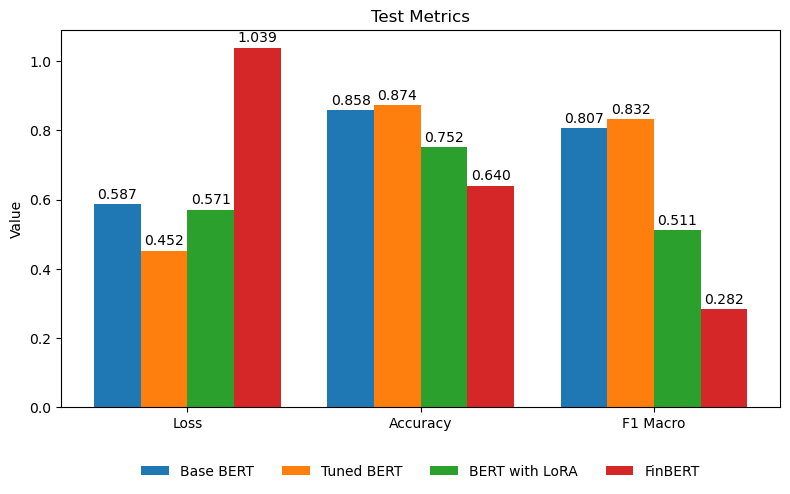

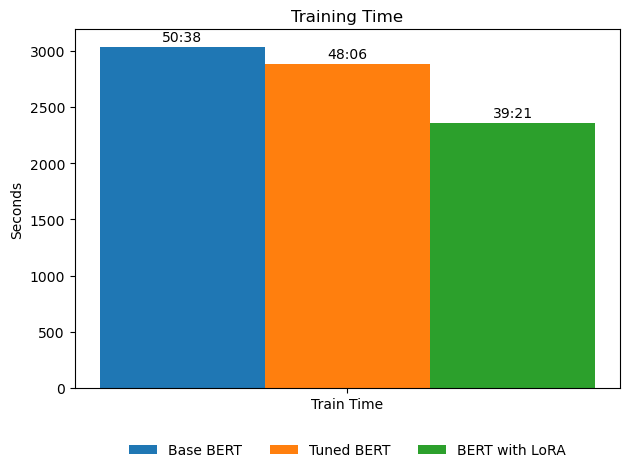

In [ ]:
# test metrics (rounded to 5 d.p.)
results = {
    "Base BERT": {"loss": 0.58719, "accuracy": 0.85846, "f1_macro": 0.80690, "train_time_secs": 3038.16952},
    "Tuned BERT": {"loss": 0.45159, "accuracy": 0.87395, "f1_macro": 0.83198, "train_time_secs": 2886.48378},
    "BERT with LoRA": {"loss": 0.57092, "accuracy": 0.75168, "f1_macro": 0.51115, "train_time_secs": 2360.90382},
    "FinBERT": {"loss": 1.03918, "accuracy": 0.64028, "f1_macro": 0.28204},
}

# 2) Build DataFrame: rows = models, cols = metrics
df = pd.DataFrame.from_dict(results, orient="index")
# Choose metric order
metrics = ["loss", "accuracy", "F1_macro"]
df = df[metrics]

# 3) Clustered bars with x-axis = metrics, bars = models
def plot_grouped_by_metric(df, title="Test Metrics"):
    models  = df.index.tolist()
    metrics = df.columns.tolist()
    x = np.arange(len(metrics))
    n_models = len(models)
    total_width = 0.8
    bar_w = total_width / n_models
    offsets = np.linspace(-total_width/2 + bar_w/2, total_width/2 - bar_w/2, n_models)

    fig, ax = plt.subplots(figsize=(8, 5))

    for i, model in enumerate(models):
        vals = df.loc[model, metrics].values.astype(float)
        bars = ax.bar(x + offsets[i], vals, width=bar_w, label=model)
        for b, v in zip(bars, vals):
            ax.annotate(f"{v:.3f}", (b.get_x() + b.get_width()/2.0, b.get_height()),
                        ha="center", va="bottom", xytext=(0, 2), textcoords="offset points")

    ax.set_xticks(x)
    ax.set_xticklabels([m.replace("_"," ").title() for m in metrics])
    ax.set_ylabel("Value")
    ax.set_title(title)

    # Put legend outside (right) so it never blocks bars/labels
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=min(n_models, 4), frameon=False)
    plt.subplots_adjust(bottom=0.2)
    plt.tight_layout()
    plt.show()

plot_grouped_by_metric(df)

# Build a time-only DataFrame for training time (skip missing (FinBERT))
df_time = pd.DataFrame.from_dict(results, orient="index")[["train_time_secs"]].dropna()
def _fmt_time(sec):
    sec = int(round(float(sec)))
    h, r = divmod(sec, 3600)
    m, s = divmod(r, 60)
    return f"{h:d}:{m:02d}:{s:02d}" if h else f"{m:02d}:{s:02d}"

def plot_grouped_time(df_time, title="Training Time"):
    if df_time.empty:
        print("No training time data.")
        return

    models = df_time.index.tolist()
    time_metrics = ["train_time_secs"]  # extend if you add more time keys later
    x = np.arange(len(time_metrics))    # one group for 'Train Time'
    n_models = len(models)
    total_width = 0.8
    bar_w = total_width / n_models
    offsets = np.linspace(-total_width/2 + bar_w/2, total_width/2 - bar_w/2, n_models)

    plt.figure()
    ax = plt.gca()

    for i, model in enumerate(models):
        val = float(df_time.loc[model, "train_time_secs"])
        bar = ax.bar(x + offsets[i], [val], width=bar_w, label=model)[0]
        ax.annotate(_fmt_time(val),
                    (bar.get_x() + bar.get_width()/2.0, bar.get_height()),
                    ha="center", va="bottom", xytext=(0, 2), textcoords="offset points")

    ax.set_xticks(x)
    ax.set_xticklabels(["Train Time"])
    ax.set_ylabel("Seconds")
    ax.set_title(title)
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=min(n_models, 4), frameon=False)
    plt.subplots_adjust(bottom=0.2)
    plt.tight_layout()
    plt.show()

plot_grouped_time(df_time)